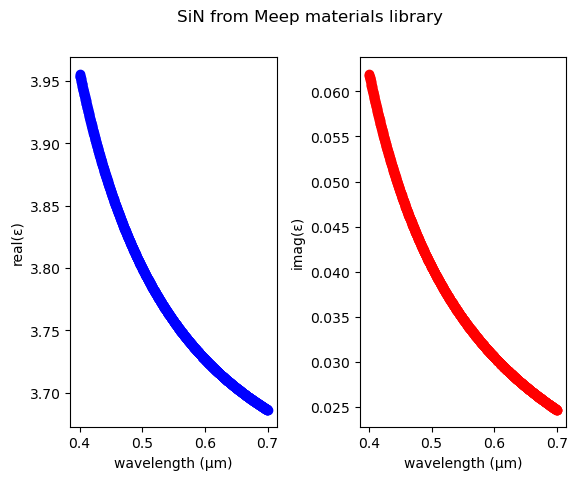

In [19]:
import meep as mp
import meep.adjoint as mpa
from meep.materials import SiN
import numpy as np
import matplotlib.pyplot as plt

um_scale = 2
resolution = 20

wvl_min = 0.4 # units of μm
wvl_max = 0.7 # units of μm
nwvls = 1000
wvls = np.linspace(wvl_min, wvl_max, nwvls)

SiN_epsilon = np.array([SiN.epsilon(1/w)[0][0] for w in wvls])

plt.subplot(1,2,1)
plt.plot(wvls,np.real(SiN_epsilon),'bo-')
plt.xlabel('wavelength (μm)')
plt.ylabel('real(ε)')

plt.subplot(1,2,2)
plt.plot(wvls,np.imag(SiN_epsilon),'ro-')
plt.xlabel('wavelength (μm)')
plt.ylabel('imag(ε)')

plt.suptitle('SiN from Meep materials library')
plt.subplots_adjust(wspace=0.4)
plt.show()

-----------
Initializing structure...
time for choose_chunkdivision = 5.96046e-06 s
Working in 2D dimensions.
Computational cell is 10 x 10 x 0 with resolution 20
time for set_epsilon = 0.021436 s
time for set_conductivity = 0.000693083 s
time for set_conductivity = 0.000689983 s
time for set_conductivity = 0.000695944 s
time for set_conductivity = 0.000695944 s
time for set_conductivity = 0.000691891 s
time for set_conductivity = 0.000703096 s
lorentzian susceptibility: frequency=5.23857, gamma=0.321009
-----------
field decay(t = 2.025): 5.638747595508056e-114 / 5.638747595508056e-114 = 1.0
field decay(t = 3.0500000000000003): 3.933222717887304e-45 / 3.933222717887304e-45 = 1.0
field decay(t = 4.05): 1.6247433334107543e-25 / 1.6247433334107543e-25 = 1.0
field decay(t = 5.075): 1.5998701505814255e-19 / 1.5998701505814255e-19 = 1.0
field decay(t = 6.1000000000000005): 2.1640919930304502e-11 / 2.1640919930304502e-11 = 1.0
field decay(t = 7.125): 2.8696934480214958e-05 / 2.86969344802149

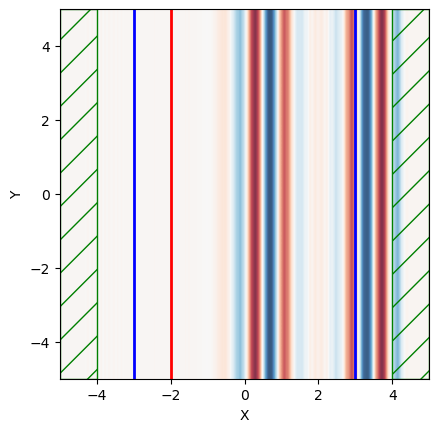

In [20]:
# SiN = mp.Medium(index=2)

pml_layers = [mp.Absorber(thickness=1, direction = mp.X)]
# pml_layers = [mp.PML(thickness=1)]
cell_size = mp.Vector3(10,10)

fcen = (1/(0.40 * um_scale) + 1/(0.70 * um_scale))/2
df = (1/(0.40 * um_scale) - 1/(0.70 * um_scale))
nfreq = 100

src = mp.GaussianSource(fcen, df, is_integrated=True)

sources = [mp.Source(src, component=mp.Ez, size=mp.Vector3(y=10), center=mp.Vector3(-2))]





geometry=[]


sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    extra_materials=[SiN],
                    k_point=mp.Vector3(0,0,0))

# reflected flux
refl_fr = mp.FluxRegion(
    center=mp.Vector3(-3, 0, 0), size=mp.Vector3(0, 10, 0)
)
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

# transmitted flux
tran_fr = mp.FluxRegion(
    center=mp.Vector3(3, 0, 0), size=mp.Vector3(0, 10, 0)
)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)



pt = mp.Vector3(4, 8, 0) #pt는 transmitted flux region과 동일

sim.run(until_after_sources=mp.stop_when_fields_decayed(1,mp.Ez,pt,1e-5))

plt.figure(dpi=100)
sim.plot2D(fields=mp.Ez)
plt.show()

In [21]:
straight_refl_data = sim.get_flux_data(refl)
straight_tran_flux = mp.get_fluxes(tran)

In [22]:
sim.reset_meep()

-----------
Initializing structure...
time for choose_chunkdivision = 1.00136e-05 s
Working in 2D dimensions.
Computational cell is 10 x 10 x 0 with resolution 20
     block, center = (2,0,0)
          size (0.3,10,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.32,2.32,2.32)
time for set_epsilon = 0.0252888 s
time for set_conductivity = 0.000802994 s
time for set_conductivity = 0.000815868 s
time for set_conductivity = 0.00080514 s
time for set_conductivity = 0.00080514 s
time for set_conductivity = 0.0008111 s
time for set_conductivity = 0.000805855 s
lorentzian susceptibility: frequency=5.23857, gamma=0.321009
-----------
field decay(t = 2.025): 5.638747595508056e-114 / 5.638747595508056e-114 = 1.0
field decay(t = 3.0500000000000003): 3.933222717887304e-45 / 3.933222717887304e-45 = 1.0
field decay(t = 4.05): 1.6247433334107543e-25 / 1.6247433334107543e-25 = 1.0
field decay(t = 5.075): 1.599914112136082e-19 / 1.599914112136082e-19 = 1.0

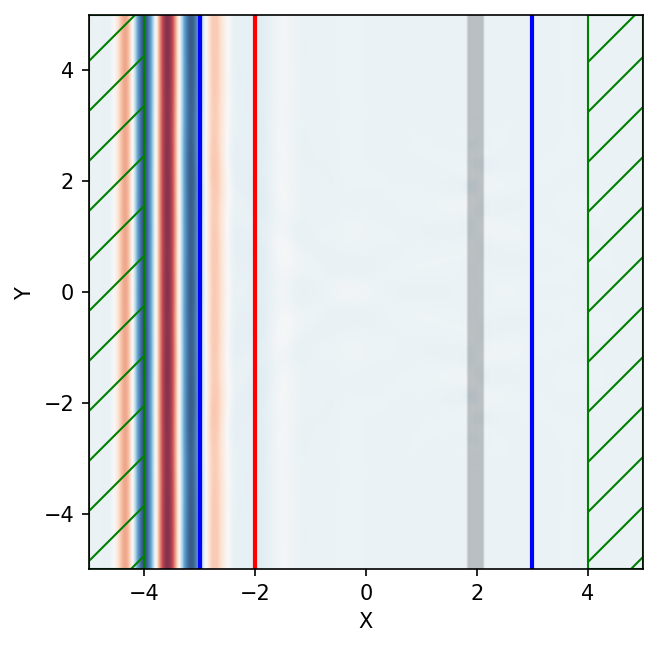

In [23]:
geometry = [mp.Block(
        mp.Vector3(0.3, 10, 0),
        center=mp.Vector3(2,0),
        material=SiN
    )]

sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    extra_materials=[SiN],
                    k_point=mp.Vector3(0,0,0)
                    )

# reflected flux
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# for normal run, load negated fields to subtract incident from refl. fields
sim.load_minus_flux_data(refl, straight_refl_data)

pt = mp.Vector3(4, 8, 0) #pt는 transmitted flux region과 동일

sim.run(until_after_sources=mp.stop_when_fields_decayed(1,mp.Ez,pt,1e-5))
# sim.run(until=16)

bend_refl_flux = mp.get_fluxes(refl)
bend_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)

plt.figure(dpi=150)
sim.plot2D(fields=mp.Ez)
plt.show()

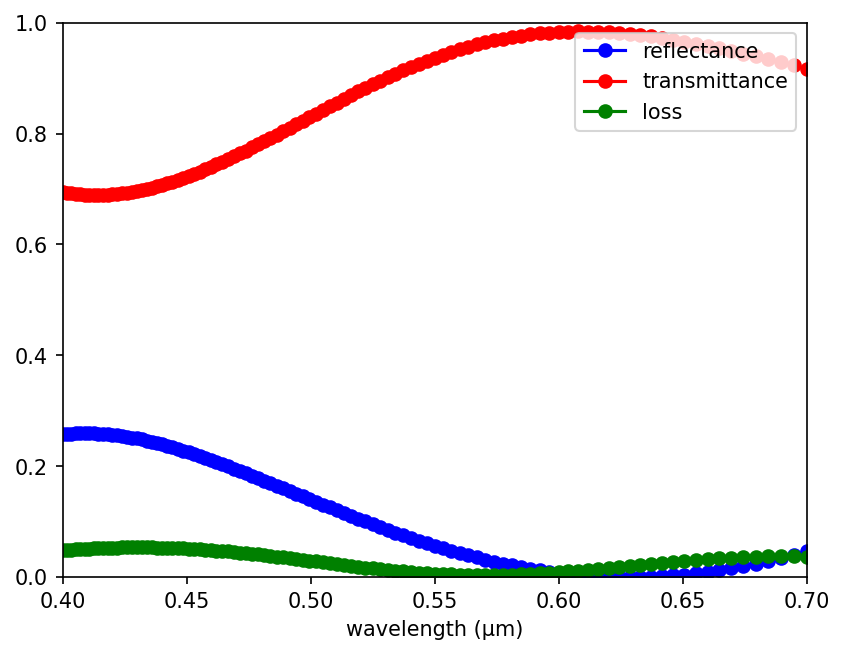

In [24]:
wl = [] #resolution 50
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Rs = np.append(Rs, -bend_refl_flux[i] / straight_tran_flux[i])
    Ts = np.append(Ts, bend_tran_flux[i] / straight_tran_flux[i])

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Rs, "bo-", label="reflectance")
    plt.plot(wl, Ts, "ro-", label="transmittance")
    plt.plot(wl, 1 - Rs - Ts, "go-", label="loss")
    plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.legend(loc="upper right")
    plt.show()

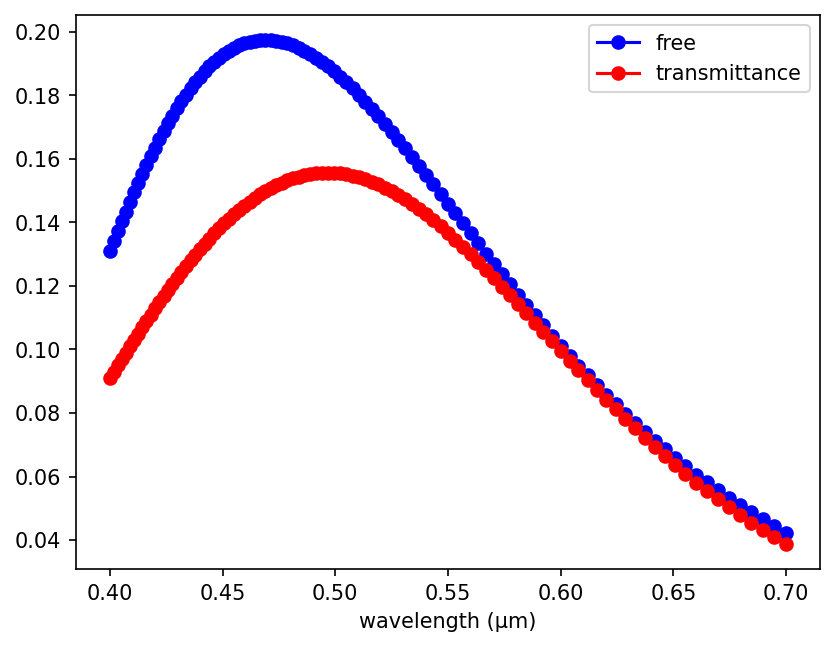

In [25]:
wl = [] #resolution 50
Rst = []
Tst = []
for i in range(nfreq):
    wl = np.append(wl, 1 / (flux_freqs[i] * um_scale))
    Rst = np.append(Rst, straight_tran_flux[i])
    Tst = np.append(Tst, bend_tran_flux[i])

if mp.am_master():
    plt.figure(dpi=150)
    plt.plot(wl, Rst, "bo-", label="free")
    plt.plot(wl, Tst, "ro-", label="transmittance")
    # plt.plot(wl, 1 - Rs - Ts, "go-", label="loss")
    # plt.axis([0.40, 0.70, 0, 1])
    plt.xlabel("wavelength (μm)")
    plt.legend(loc="upper right")
    plt.show()

In [26]:
np.savetxt("Reflection_my_code.txt",Rs)
np.savetxt("Transmission_my_code.txt",Ts)